# CNN-VAE on HUTUBS dataset

In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
import os
import time
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io as sio
from IPython.display import display

from utils_data import load_hutubs_depth, load_hutubs_hrtf, load_ami
from utils_model import create_model, create_model_fconv, create_model_fconv_inception
from utils_train import train_model
from utils_plot import plot_latent_space, plot_latent_pairs, plot_reconstructions, plot_xcorr

## Load data
```py
[72, 61, 46, 63, 90, 31, 66, 91, 22, 80, 
 45, 62, 33, 21,  9, 10, 47, 89, 69, 16, 
 19, 48, 60, 95, 55, 68, 20, 59, 44, 40, 
 82, 70,  3, 58, 71, 67, 76, 32, 77,  2, 
  8, 30, 78, 81,  6, 57, 73,  4,  5, 11, 
 23, 49, 29, 41, 12]
 ```

In [85]:
# pick dataset to load
dataset = 'hutubs_hrtf'
# HRTFs from HUTUBS 
if dataset == 'hutubs_hrtf':
    filters = {
        #'ears': ['right'],
        #'ids': range(1,30),
        'freqs': sio.loadmat('./data/hutubs_hrtf/configs.mat')['f'][0][5:92],
    }
    (x_train, y_train), (x_test, y_test) = load_hutubs_hrtf(
        dataset_path='./data/hutubs_hrtf/', 
        anthropometrics_path='./data/hutubs_measures.csv', 
        data_content='hrtfs',
        user_filters=filters)
# depthmaps from HUTUBS (augmented) 
elif dataset == 'hutubs_depth':
    filters = {
        'ears': ['right'],
        #'ids': [8, 80], #, 81, 82, 90, 91],
        'xoffs': [0], #[-0.0066, -0.0033, 0.0, 0.0033,  0.0066],
        'yoffs': [0], #[-0.0025, 0.0, 0.00249],
        'azimuths': [0], #[-16, -8, 0, 8, 16],
        'elevations': [0] #[-16, -8, 0, 8, 16]
    }
    (x_train, y_train), (x_test, y_test) = load_hutubs_depth(
        dataset_path='./data/hutubs_img3/', 
        anthropometrics_path='./data/hutubs_measures.csv', 
        user_filters=filters,
        saltpepper=0)
# AMI ear pictures
elif dataset == 'ami':
    filters = {
        #'ids': [8, 80, 81, 82, 90, 91],
        'variations': ['left', 'right', 'front', 'up', 'down', 'zoom']
    }
    (x_train, y_train), (x_test, y_test) = load_ami(
        dataset_path='./data/ami/',
        size=(96, 96),
        user_filters=filters,
        saltpepper=100)

# show resulting data shapes
print('train set:', x_train.shape)
print('test set: ', x_test.shape)

# reshape to fit keras format
image_size = x_train.shape[1:3]
x_train = np.reshape(x_train, [-1, *image_size, 1])
x_test = np.reshape(x_test, [-1, *image_size, 1])
# if images, normalize range
if dataset != 'hutubs_hrtf':
    x_train = x_train.astype('float32') / 255
    x_test = x_test.astype('float32') / 255
# adjust shape to be power of 2
x_train = x_train[:, -32:]
x_test = x_test[:, -32:]
image_size = x_train.shape[1:3]

  1%|          | 100/16704 [00:00<00:16, 994.53it/s]

Train/test split: 72/24 ids


100%|██████████| 16704/16704 [00:16<00:00, 1039.40it/s]

train set: (12528, 36, 72)
test set:  (4176, 36, 72)


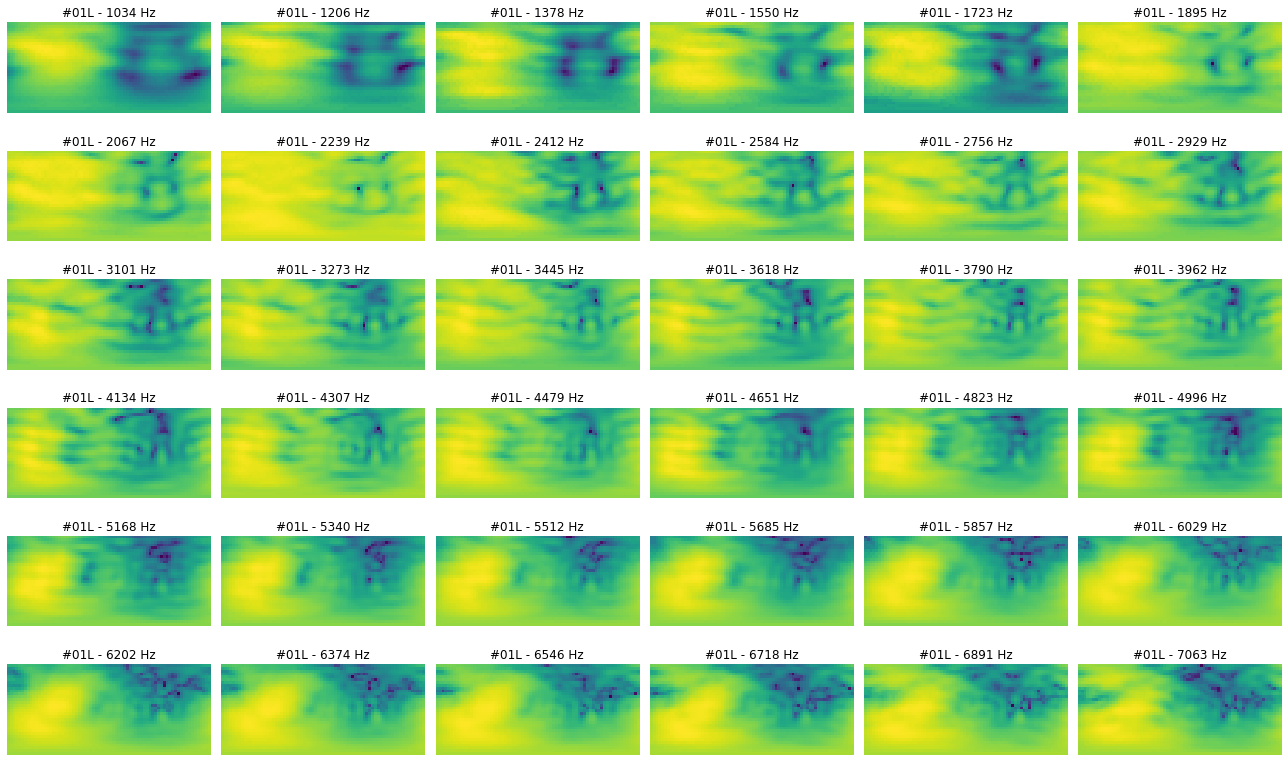

In [86]:
fig, ax = plt.subplots(6,6, figsize=(18,11))
for i, a in enumerate(ax.flatten()):
    n = int(float(len(x_train) / len(ax.flatten()) * i))
    a.imshow(x_train[i,...,0])
    #a.set_title(str(n))
    a.set_title('#{:02}{} - {:.0f} Hz'.format(
        y_train['id'].iloc[i], 
        y_train['ear'].iloc[i][0].upper(), 
        y_train['freq'].iloc[i]))
    #a.imshow(x_train[i,...,0])
    a.axis('off')
plt.tight_layout()

## Create network

In [21]:
# network parameters
modelname = 'fconv'
input_shape = (*image_size, 1)
filters_layers = [256, 128, 64][::-1]
kernel_size = 3
n_latent = 16
use_batchnorm = True
use_maxpool = True
freq_loss = True

if modelname=='fconv':
    # create fully-conv net
    encoder, decoder, vae = create_model_fconv(
        input_shape=input_shape, filters_layers=filters_layers, 
        kernel_size=kernel_size,n_latent=n_latent, 
        use_batchnorm=use_batchnorm,use_maxpool=use_maxpool, 
        gen_plots=False, freq_loss=freq_loss)

elif modelname=='incept':
    encoder, decoder, vae = create_model_fconv_inception(
        input_shape=input_shape, filters_layers=filters_layers, 
        kernel_size=kernel_size,n_latent=n_latent, 
        use_batchnorm=use_batchnorm,use_maxpool=use_maxpool, 
        gen_plots=False, freq_loss=freq_loss)
    
else:
    n_layers = 3
    n_filters = 16
    n_inter = 32
    encoder, decoder, vae = create_model(
        input_shape=input_shape, n_layers=n_layers, n_filters=n_filters, 
        kernel_size=kernel_size, n_inter=n_inter, n_latent=n_latent, 
        use_batchnorm=use_batchnorm, use_maxpool=use_maxpool, 
        gen_plots=False, freq_loss=freq_loss)
    
# pre-compute some info for training
curr_epoch = 0
log_id = int(time.time()) % 99999999
tensorboard_destination = f'./logs/{log_id}'

# store logs
logs_df = pd.read_pickle('./logs.pkl')
logs_df.loc[log_id] = {
    'modelname': modelname,
    'input_shape': input_shape,
    'filters_layers': filters_layers,
    'kernel_size': kernel_size,
    'n_latent': n_latent,
    'use_batchnorm': use_batchnorm,
    'use_maxpool': use_maxpool,
    'freq_loss': freq_loss,
    'date_time': datetime.datetime.now()
}
logs_df.to_pickle('./logs.pkl')
display(logs_df)

adding encoder stack 0..
adding encoder stack 1..
adding encoder stack 2..
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 32, 72, 1)    0                                            
__________________________________________________________________________________________________
encoder_0_conv (Conv2D)         (None, 32, 72, 64)   640         encoder_input[0][0]              
__________________________________________________________________________________________________
encoder_0_bnorm (BatchNormaliza (None, 32, 72, 64)   256         encoder_0_conv[0][0]             
__________________________________________________________________________________________________
encoder_0_act (Activation)      (None, 32, 72, 64)   0           encoder_0_bnorm[0][0]            
__________________________________

,modelname,input_shape,filters_layers,kernel_size,n_latent,use_batchnorm,use_maxpool,freq_loss,date_time
log_id,,,,,,,,,
71333216,fconv,"(32, 72, 1)","[64, 128, 256]",3,16,True,True,True,2019-10-17 19:26:41.939680
71333388,fconv,"(32, 72, 1)","[64, 128, 256]",3,16,True,True,True,2019-10-17 19:29:33.239074


## Train network

In [93]:
# training parameters
batch_size = x_train.shape[0] // 16
print(batch_size)
epochs = 100
validation_freq = 5
earlystopping_patience = -50
checkpoint_destination = None #'./models/{epoch.h5}'
cuda_device = '2'
tqdm_bar = True
# train the autoencoder
epochs_range = [curr_epoch, curr_epoch+epochs]
label_train = ((y_train['freq'] - y_train['freq'].mean()) / y_train['freq'].std()).astype(float) if freq_loss else None
label_test = ((y_test['freq'] - y_test['freq'].mean()) / y_test['freq'].std()).astype(float)  if freq_loss else None
print(f'Training log: {tensorboard_destination}')
print(f'Training from {epochs_range[0]} to {epochs_range[1]}..')
trainig_history = train_model(vae, x_train, label_train, 
                              x_test, label_test, 
                              batch_size, epochs_range=epochs_range,
                              validation_freq=validation_freq,
                              tqdm_bar=tqdm_bar,
                              earlystopping_patience=earlystopping_patience, 
                              checkpoint_destination=checkpoint_destination, 
                              tensorboard_destination=tensorboard_destination, 
                              cuda_device=cuda_device)

curr_epoch += trainig_history.index[-1]

783
Training log: ./logs/71333388
Training from 1947 to 2047..


loss: 13.25: 100%|██████████| 100/100 [09:09<00:00,  5.50s/it]


## Plot results

minimum los\s:  13.503362953662872


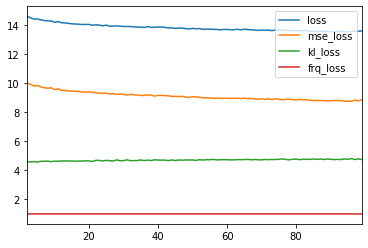

In [88]:
trainig_history.iloc[2:].plot()
print('minimum los\s: ', trainig_history['loss'].min())

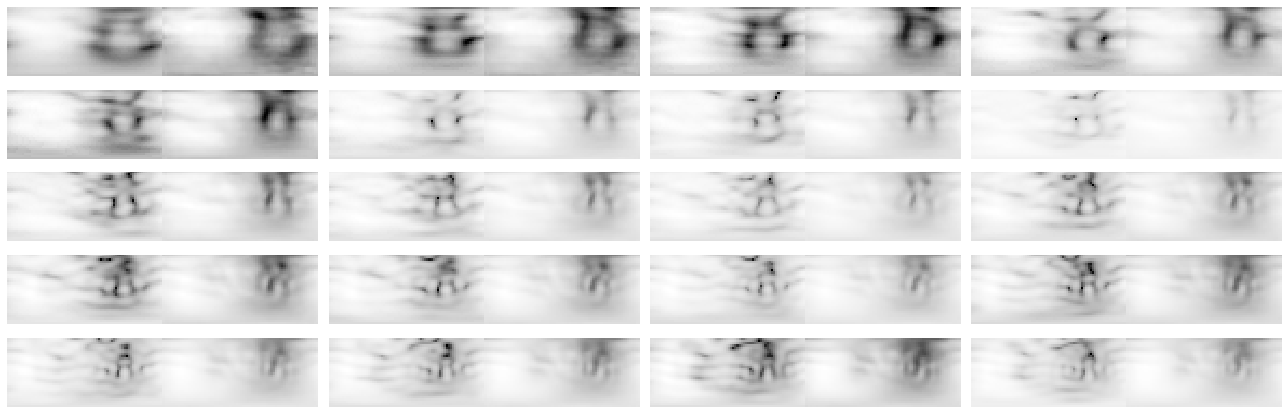

In [94]:
# take data
data_train = (x_train, ((y_train['freq'] - y_train['freq'].mean()) / y_train['freq'].std()).astype(float))
data_test = (x_test, ((y_test['freq'] - y_test['freq'].mean()) / y_test['freq'].std()).astype(float))

# plot reconstructions
fig, axs = plt.subplots(5, 4, figsize=(18, 6))
plot_reconstructions(encoder, decoder, data_train, axs=axs, batch_size=batch_size)
fig.tight_layout()

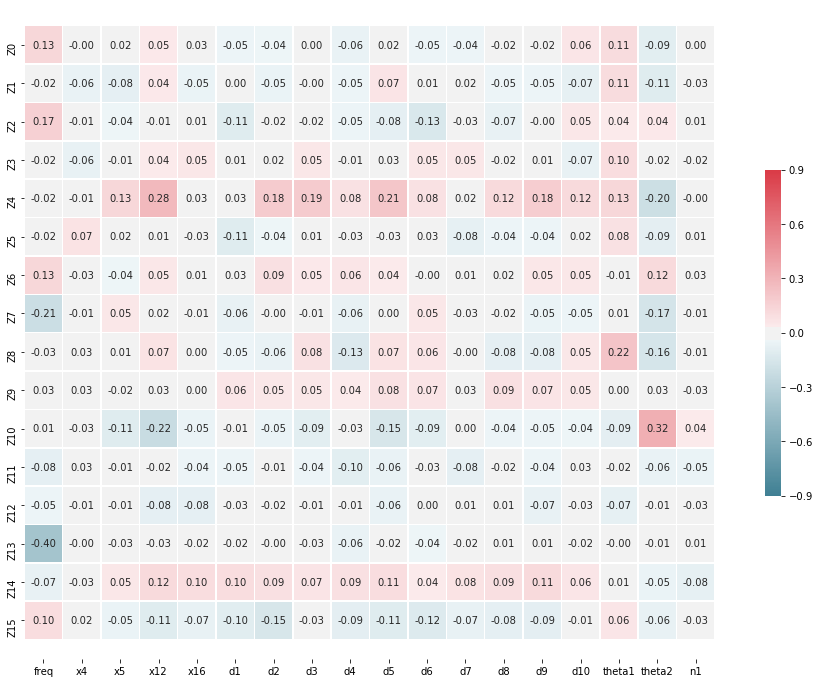

In [95]:
# data to use
drop_cols = ['ear', 'id', 'x6', 'x7', 'x8', 'x9', 'x14', 'x17', 'x2', 'x3', 'x1']
#data_train = (x_train, y_train.drop(columns=['elevation', 'azimuth', 'xoffs', 'yoffs', *drop_cols]).astype(float))
data_train = (x_train, y_train.drop(columns=drop_cols).astype(float))
data_test = (x_test, y_test.drop(columns=drop_cols).astype(float))

# plot correlation
fig, ax = plt.subplots(1, 1, figsize=(18, 12))
plot_xcorr(encoder, data_train, ax,
           batch_size=batch_size, pca=False,
           labels=True)

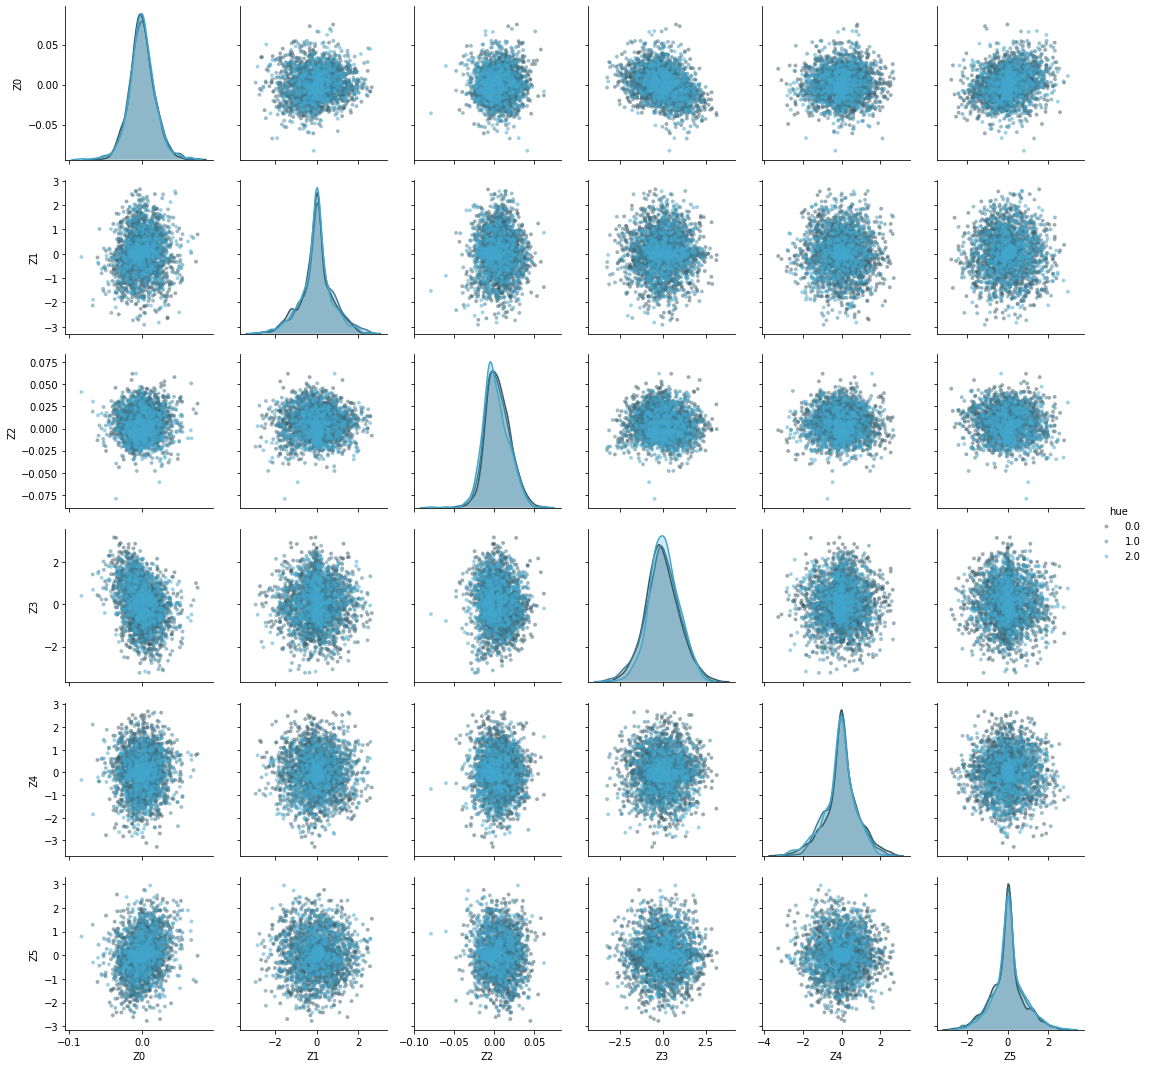

In [96]:
# plot PC
data_train = (x_train[::2], y_train['id'].iloc[::2])
data_test = (x_test, y_test['freq'])
plot_latent_pairs(encoder, data_train,
                  batch_size=batch_size, n_pca=False, n_dim=6, plot_kws=dict(edgecolor='none', alpha=0.5, s=15))

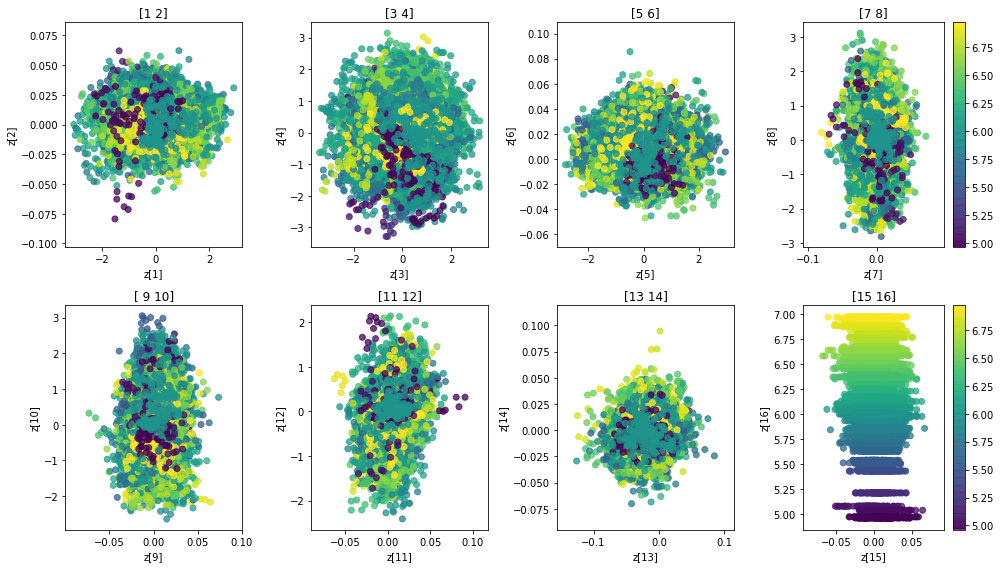

In [97]:
#data_train = (x_train, y_train['id'].astype('category').cat.codes)
#data_test = (x_test, y_test['id'].astype('category').cat.codes)
data_train = (x_train, y_train['d5'])

# plot latent dims
fig, axs = plt.subplots(2, n_latent//4, figsize=(14, 8))
combinations = np.arange(n_latent).reshape((n_latent//2, 2))
for i, dims in enumerate(combinations): 
#for dims in [[14, 15]]:
    dims += 1
    plot_latent_space(encoder, data_train, axs.flatten()[i],
                      batch_size=batch_size, dims=dims, 
                      colorbar=(i%4==3), use_pca=False)
fig.tight_layout()

In [ ]:
# TODO:
# - 3d plots
# - hyperparam opt: `talos`
# - noise solo a input
# - train con 'cubo' (elevation, azimuth, frequency) https://www.sciencedirect.com/science/article/pii/S0925231215014940
# - semisupervised learning http://bjlkeng.github.io/posts/semi-supervised-learning-with-variational-autoencoders/
# - inception layers (unabridged) https://becominghuman.ai/understanding-and-coding-inception-module-in-keras-eb56e9056b4b
# - plot: tsne on latent space
# - extract hrtf/hrir
# - plot: hrtf/hrir
# - freq_loss: pearson vs mse?
# - store and load trained model

In [13]:
## NOTE: only run if there's no existing log file!
logs_df = pd.DataFrame(columns=[
    'modelname', 'input_shape', 'filters_layers', 
    'kernel_size', 'n_latent', 'use_batchnorm', 
    'use_maxpool', 'freq_loss', 'date_time'])
logs_df.index.name = 'log_id'
logs_df.to_pickle('./logs.pkl')

